In [17]:
# Install dependencies
!pip install PyMuPDF tensorflow scikit-learn matplotlib pandas


In [18]:
import fitz  # PyMuPDF
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Helper function to read PDF and extract text
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        text += page.get_text("text")
    return text


In [19]:
from google.colab import files

# Upload PDF
uploaded = files.upload()

# Assume you have one file, extract its name
pdf_file_name = list(uploaded.keys())[0]

# Extract text from PDF
document_text = extract_text_from_pdf(pdf_file_name)
print(f"Extracted {len(document_text)} characters from the PDF.")


Saving 1st Grade Worksheets all the files merged.pdf to 1st Grade Worksheets all the files merged.pdf
Extracted 46332 characters from the PDF.


In [20]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Dummy data preparation: simulate labels based on sentence length
labels = []
texts = []

# Tokenize document into sentences instead of paragraphs
sentences = sent_tokenize(document_text)

# Create labels based on sentence length, modify as per the task
for sentence in sentences:
    if len(sentence) > 50:  # Simple rule, modify as needed
        labels.append('Category A')
    else:
        labels.append('Category B')
    texts.append(sentence)

# Ensure we have enough data
if len(texts) < 2:
    print("Warning: Not enough data to split into training and test sets. Proceeding with all data for training.")

# Encode the labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Prepare tokenizer and sequences
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, padding='post')

# Check if we have enough samples to split
if len(padded_sequences) > 1:
    # Split the data if there is more than 1 sample
    X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)
else:
    # Use all data for training if splitting isn't possible
    X_train, X_test, y_train, y_test = padded_sequences, padded_sequences, encoded_labels, encoded_labels

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")


Training samples: 461, Test samples: 116


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

# Build a simple model with Dropout and L2 Regularization
model = tf.keras.Sequential([
    # Embedding layer
    tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=padded_sequences.shape[1]),

    # GlobalAveragePooling layer
    tf.keras.layers.GlobalAveragePooling1D(),

    # Dense layer with L2 regularization
    tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=regularizers.l2(0.01)),

    # Dropout layer to prevent overfitting
    Dropout(0.5),  # 50% dropout rate, you can adjust this

    # Output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add EarlyStopping callback to stop training when the validation loss doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(
    X_train,
    y_train,
    epochs=200,  # Reduce the number of epochs
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],  # Use EarlyStopping
    verbose=2
)


Epoch 1/200
15/15 - 2s - 157ms/step - accuracy: 0.5922 - loss: 0.8668 - val_accuracy: 0.6638 - val_loss: 0.8264
Epoch 2/200
15/15 - 0s - 21ms/step - accuracy: 0.6377 - loss: 0.8113 - val_accuracy: 0.6638 - val_loss: 0.7768
Epoch 3/200
15/15 - 0s - 19ms/step - accuracy: 0.6399 - loss: 0.7876 - val_accuracy: 0.6638 - val_loss: 0.7491
Epoch 4/200
15/15 - 0s - 8ms/step - accuracy: 0.6421 - loss: 0.7647 - val_accuracy: 0.6638 - val_loss: 0.7305
Epoch 5/200
15/15 - 0s - 7ms/step - accuracy: 0.6443 - loss: 0.7542 - val_accuracy: 0.6638 - val_loss: 0.7189
Epoch 6/200
15/15 - 0s - 10ms/step - accuracy: 0.6464 - loss: 0.7326 - val_accuracy: 0.6638 - val_loss: 0.7021
Epoch 7/200
15/15 - 0s - 8ms/step - accuracy: 0.6486 - loss: 0.7145 - val_accuracy: 0.6724 - val_loss: 0.6851
Epoch 8/200
15/15 - 0s - 7ms/step - accuracy: 0.6659 - loss: 0.7046 - val_accuracy: 0.6810 - val_loss: 0.6752
Epoch 9/200
15/15 - 0s - 6ms/step - accuracy: 0.6573 - loss: 0.6945 - val_accuracy: 0.6897 - val_loss: 0.6616
Epoch

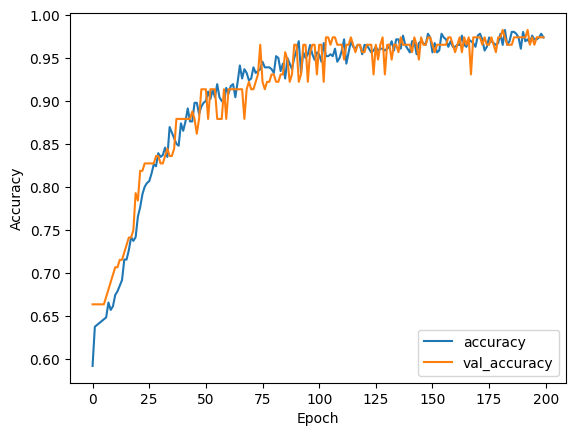

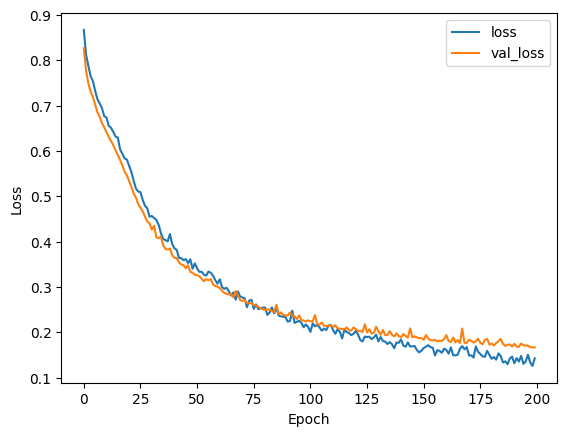

In [30]:
# Plot accuracy and loss over epochs
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


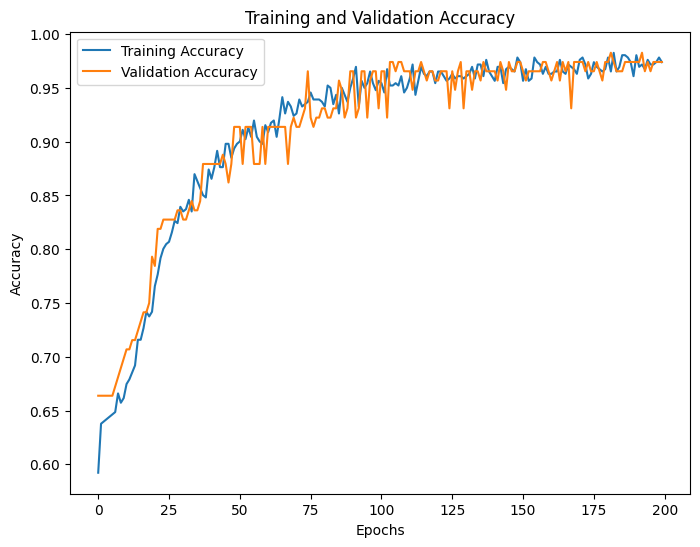

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


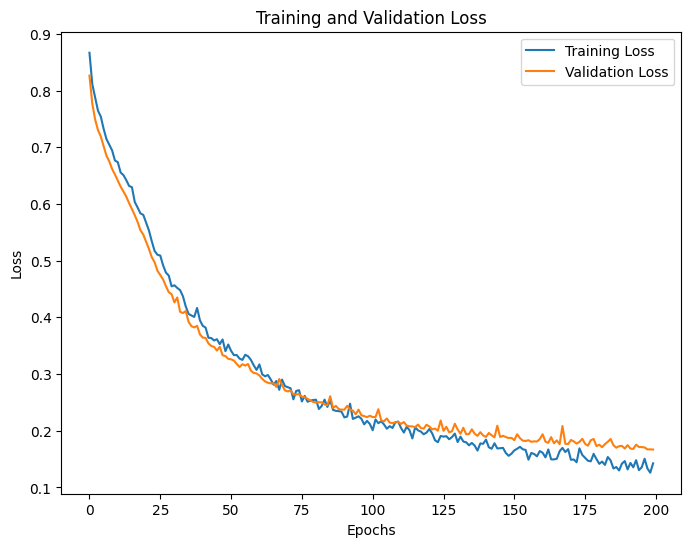

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


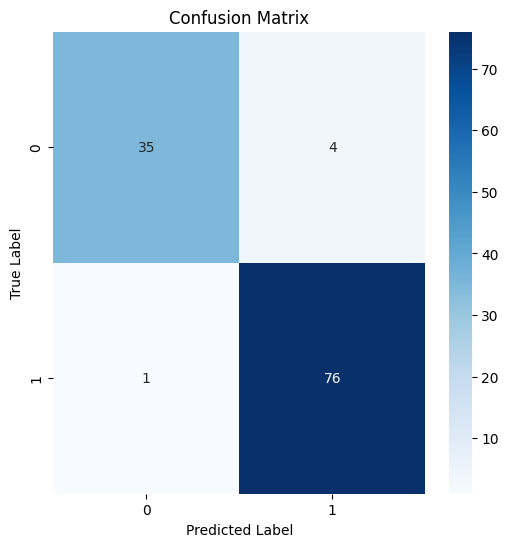

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # For binary classification
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


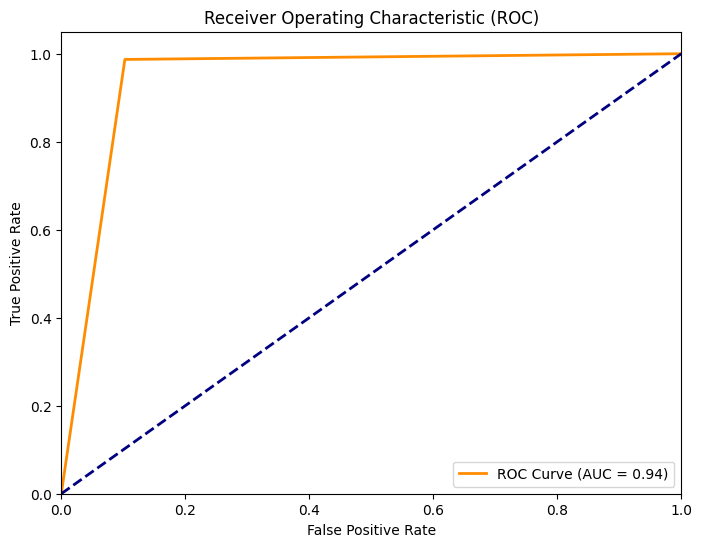

In [26]:
from sklearn.metrics import roc_curve, auc

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [27]:
# Save the trained model
model.save('trained_model.h5')

# Download the model
from google.colab import files
files.download('trained_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>